In [37]:
from google.colab import drive
import tensorflow as tf
from tf_keras import Sequential
from tf_keras.preprocessing.image import ImageDataGenerator
from tf_keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from tf_keras.metrics import Accuracy, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tf_keras.preprocessing import image
from tf_keras.models import load_model

Подключился к своему диску, чтобы брать оттуда датасет

In [27]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/Артефакты проекта/dataset/train'
test_dir = '/content/drive/MyDrive/Артефакты проекта/dataset/test'

Выполним аугментацию изображений, поскольку имеем маленький датасет. Для тренировочных данных применяем различные вариации изменения масштаба, поворота, яркости и т.д., чтобы нейросеть точнее распознавала качество лица в разных условиях. В данных для теста применяем только нормализацию

In [4]:
augmentation_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=20.0,
    fill_mode='nearest',
    horizontal_flip=True,
)

augmentation_test = ImageDataGenerator(rescale=1./255)

Создаём новые изображения, используя аугментацию и исходный датасет

In [5]:
train_generator = augmentation_train.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=16,
    class_mode='binary'
)

test_generator = augmentation_test.flow_from_directory(
    test_dir,
    target_size=(512, 512),
    batch_size=16,
    class_mode='binary'
)

Found 1543 images belonging to 2 classes.
Found 914 images belonging to 2 classes.


# Создание модели

In [6]:
Neural_model = Sequential([
    Conv2D(filters= 16, kernel_size= (3,3), activation= 'relu', input_shape= (512, 512, 3)),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters= 32, kernel_size= (3,3), activation= 'relu'),
    MaxPooling2D(pool_size=(3, 3)),

    Flatten(),
    Dense(32, activation= 'relu'),
    Dropout(0.5),
    Dense(1, activation= 'sigmoid')
    ])

Neural_model.compile(
      optimizer= 'adam',
      loss= 'binary_crossentropy',
      metrics= [
          Accuracy(),
          Precision(),
          Recall(),
          TruePositives(),
          TrueNegatives(),
          FalsePositives(),
          FalseNegatives()
      ]
      )


# Обучение модели

In [7]:
results = Neural_model.fit(
    train_generator,
    epochs= 20,
    steps_per_epoch=(train_generator.n // train_generator.batch_size),
    validation_steps=(test_generator.n // test_generator.batch_size),
    validation_data= test_generator)



Epoch 1/20
96/96 [==============================] - 1201s 13s/step - loss: 0.4911 - accuracy: 0.0000e+00 - precision: 0.6794 - recall: 0.6287 - true_positives: 337.0000 - true_negatives: 832.0000 - false_positives: 159.0000 - false_negatives: 199.0000 - val_loss: 0.4814 - val_accuracy: 0.0000e+00 - val_precision: 0.6800 - val_recall: 0.8967 - val_true_positives: 408.0000 - val_true_negatives: 265.0000 - val_false_positives: 192.0000 - val_false_negatives: 47.0000
Epoch 2/20
96/96 [==============================] - 439s 5s/step - loss: 0.3420 - accuracy: 0.0000e+00 - precision: 0.8085 - recall: 0.7103 - true_positives: 380.0000 - true_negatives: 902.0000 - false_positives: 90.0000 - false_negatives: 155.0000 - val_loss: 0.4683 - val_accuracy: 0.0000e+00 - val_precision: 0.6618 - val_recall: 0.9912 - val_true_positives: 452.0000 - val_true_negatives: 225.0000 - val_false_positives: 231.0000 - val_false_negatives: 4.0000
Epoch 3/20
96/96 [==============================] - 436s 5s/step - l

# Визуализация метрик качества

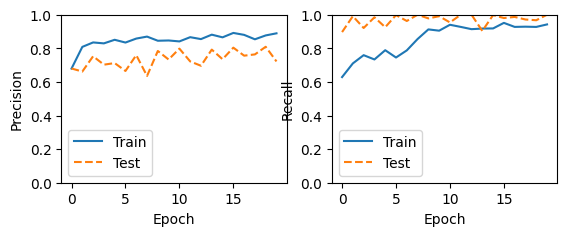

In [15]:
metrics = ['precision', 'recall']
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(results.epoch, results.history[metric], label='Train')
  plt.plot(results.epoch, results.history['val_'+metric], linestyle="--", label='Test')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.8,1])
  else:
    plt.ylim([0,1])

  plt.legend()

# Матрица ошибок

In [25]:
tp = int(results.history['true_positives'][-1])
tn = int(results.history['true_negatives'][-1])
fp = int(results.history['false_positives'][-1])
fn = int(results.history['false_negatives'][-1])

confusion_matrix = np.array([[tn, fp], [fn, tp]])

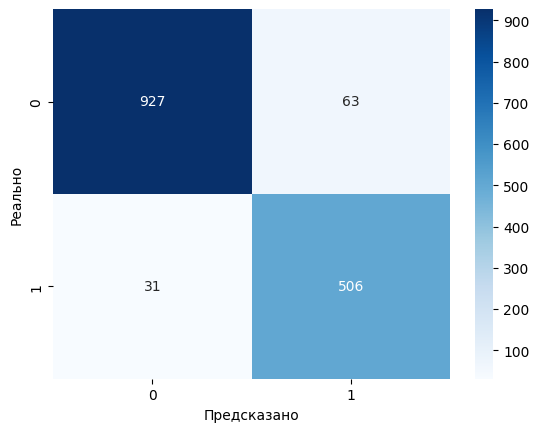

In [26]:
sns.heatmap(confusion_matrix, annot=True, fmt= 'd', cmap='Blues')
plt.xlabel('Предсказано')
plt.ylabel('Реально')
plt.show()

Тестирование функции predict()

In [34]:
img = image.load_img('/content/drive/MyDrive/Артефакты проекта/dataset/test/non-acne/face-2001-non_acne.jpg', target_size=(512, 512))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0
prediction = Neural_model.predict(img_array)
print(prediction)

1/1 [==============================] - 0s 356ms/step
[[0.98247445]]


Сохранение модели в файл

In [36]:
Neural_model.save('/content/drive/MyDrive/Артефакты проекта/Neural_model.keras')

In [38]:
def predict(image_path, model):
    img = image.load_img(image_path, target_size=(512, 512))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    return prediction


model = load_model('/content/drive/MyDrive/Артефакты проекта/Neural_model.keras')
image_path = '/content/drive/MyDrive/Артефакты проекта/dataset/test/non-acne/face-2001-non_acne.jpg'

print(predict(image_path, model))

1/1 [==============================] - 0s 125ms/step
[[0.98247445]]
